In [1]:
import sys 

In [2]:
cd '/srv/flash1/hagrawal9/project/habitat/habitat-api/'

/coc/testnvme/hagrawal9/project/habitat/habitat-api


In [3]:
import gzip
import json
import os
import sys
from typing import Any, Dict, List, Optional, Type
from copy import deepcopy

import attr
import cv2
import git
import magnum as mn
import numpy as np

# %matplotlib inline
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image


import habitat
import habitat_sim
from habitat.config import Config
from habitat.core.registry import registry
from habitat_sim.utils import viz_utils as vut
from habitat.utils.visualizations import maps, fog_of_war
from habitat.utils.visualizations.utils import observations_to_image

from rearrangement.utils.planner import (
    compute_traversable_map,
    compute_distance_using_fmm,
    find_dist_from_map,
    compute_distance_mat_using_navmesh,
    compute_distance_mat_using_fmm,
    find_shortest_path_for_multiple_objects
)
from rearrangement.utils.visualization import (
    get_top_down_map
)
from rearrangement.utils.geometry import (
     geodesic_distance
)
from collections import defaultdict

In [4]:
from habitat.datasets.rearrangement.rearrangement_dataset import RearrangementDatasetV0
from habitat.tasks.rearrangement.rearrangement_task import RearrangementEpisode

In [5]:
repo = git.Repo(".", search_parent_directories=True)
dir_path = repo.working_tree_dir
# %cd $dir_path
data_path = os.path.join(dir_path, "data")
output_directory = "data/tutorials/output/"  # @param {type:"string"}
output_path = os.path.join(dir_path, output_directory)

In [6]:
config = habitat.get_config("configs/tasks/rearrangement_gibson.yaml")

In [75]:
config.defrost()
config.SIMULATOR.INITIAL_LOOK_DOWN_ANGLE = 30
config.TASK.SENSORS =  ["GRIPPED_OBJECT_SENSOR", "ALL_OBJECT_POSITIONS", "ALL_OBJECT_GOALS", "MAP_NEXT_OBJECT_SENSOR", "CONST_MAP_NEXT_OBJECT_SENSOR"]
config.TASK.MEASUREMENTS = ['OBJECT_TO_GOAL_DISTANCE', 'AGENT_TO_OBJECT_DISTANCE', 'TOP_DOWN_MAP']
config.DATASET.SPLIT = "test"
config.DATASET.CONTENT_SCENES = ["*"]
config.ENVIRONMENT.ITERATOR_OPTIONS.SHUFFLE=False
config.freeze()

In [76]:
def print_info(obs, metrics):
    print(
        "Gripped Object: {}, Distance To Object: {}, Distance To Goal: {}".format(
            obs["gripped_object_id"],
            metrics["agent_to_object_distance"],
            metrics["object_to_goal_distance"],
        )
    )

In [77]:
try:
    env.close()
except:
    pass
env = habitat.Env(config)
fog_of_war_mask = None

2020-11-15 11:47:40,507 Initializing dataset RearrangementDataset-v0
2020-11-15 11:47:40,642 initializing sim RearrangementSim-v0


Episode Length: 0
Episode Length: 100
Episode Length: 200
Episode Length: 300
Episode Length: 400
Episode Length: 500
Episode Length: 600
Episode Length: 700
Episode Length: 800
Episode Length: 900
Episode Length: 1000


I1115 11:47:44.423874 33026 simulator.py:168] Loaded navmesh data/scene_datasets/gibson_train_val/Cokeville.navmesh
I1115 11:47:44.426380 33026 simulator.py:180] Recomputing navmesh for agent's height 0.88 and radius 0.18.
2020-11-15 11:47:44,610 Initializing task RearrangementTask-v0


In [10]:
prev_scene_id = set()

In [11]:
current_episode = None
for episode in env.episodes:
    if episode.scene_id not in prev_scene_id:
        prev_scene_id.add(episode.scene_id)
        current_episode = episode
        break

# env.current_episode.pickup_order,  env.current_episode.pickup_order_l2dist, env.current_episode.episode_id

In [12]:
env._reset_stats()

if env._current_episode is not None:
    env._current_episode._shortest_path_cache = None

env.current_episode = current_episode
env.reconfigure(env._config)
obs = env.task.reset(episode)
env._task.measurements.reset_measures(
    episode=env.current_episode, task=env.task
)
metrics = env.get_metrics()

In [13]:
prev_scene_id

{'data/scene_datasets/gibson_train_val/Cokeville.glb'}

In [78]:
obs = env.reset()

In [79]:
tdmap = env._task.sensor_suite.sensors['const_map_object'].observed_occupancy_map

In [80]:
tdmap

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])

In [81]:
tdmap1 = env._task.sensor_suite.sensors['map_object'].obstacles_mask

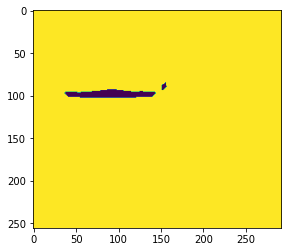

In [82]:
plt.imshow(tdmap1)

In [83]:
compute_distance_using_fmm(tdmap, )

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

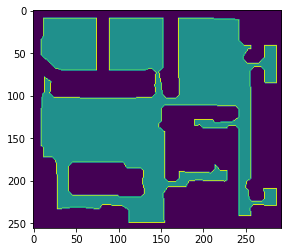

In [14]:
plt.imshow(env._task.sensor_suite.sensors['const_map_object'].top_down_map)

In [ ]:
tdmap = np.copy(top_down_map)

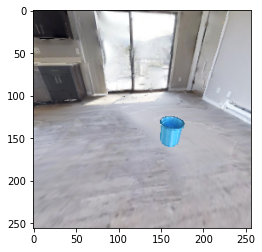

In [70]:
plt.imshow(obs['rgb'])

In [61]:
obs = env.step(0)

In [62]:
obs = env.step(1)

In [67]:
obs = env.step(2)

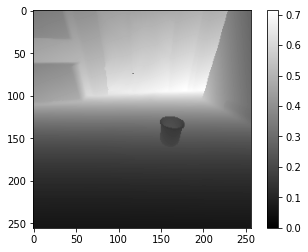

In [68]:
plt.imshow(obs['depth'].reshape((256, 256)), cmap="gray")
plt.colorbar()
plt.show()

In [85]:
agent_position = env._sim.get_agent_state().position
a_y, a_x = maps.to_grid(
    agent_position[2],
    agent_position[0],
    tdmap.shape,
    sim=env._sim,
)


In [87]:
dmap = compute_distance_using_fmm(tdmap, [a_y, a_x])

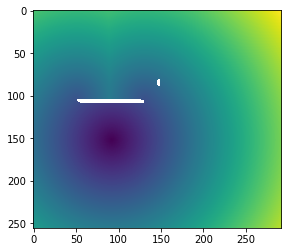

In [88]:
plt.imshow(dmap)

In [145]:
files = os.listdir('data/maps')

In [ ]:
for file in sorted(files, key=lambda x: int(x.split('_')[-1].split('.')[0])):
    # print(file)
    if 'Wells' in file:
        a = np.load('data/maps/'+file)
        plt.imshow(a)
        plt.show()

In [141]:
os.listdir('data/datasets/rearrangement/gibson/v1/test/content/')

['rearrangement_hard_v8_test_n=100_o=5_t=0.9_Sands.json.gz',
 'rearrangement_hard_v8_test_n=100_o=5_t=0.9_Howie.json.gz',
 'rearrangement_hard_v8_test_n=100_o=5_t=0.9_Starks.json.gz',
 'rearrangement_hard_v8_test_n=100_o=5_t=0.9_Stockertown.json.gz',
 'rearrangement_hard_v8_test_n=100_o=5_t=0.9_Cokeville.json.gz',
 'rearrangement_hard_v8_test_n=100_o=5_t=0.9_Sagerton.json.gz',
 'rearrangement_hard_v8_test_n=100_o=5_t=0.9_Southfield.json.gz',
 'rearrangement_hard_v8_test_n=100_o=5_t=0.9_Spencerville.json.gz',
 'rearrangement_hard_v8_test_n=100_o=5_t=0.9_Silerton.json.gz',
 'rearrangement_hard_v8_test_n=100_o=5_t=0.9_Wells.json.gz']

In [ ]:
potentially working:  
'rearrangement_hard_v8_test_n=100_o=5_t=0.9_Southfield.json.gz', 'fEvzPSo8M7gxGFr2tqc6pq'  (0)
'rearrangement_hard_v8_test_n=100_o=5_t=0.9_Sagerton.json.gz', 'GmnXbZH9zvtDmWzFRVpgkx'
'rearrangement_hard_v8_test_n=100_o=5_t=0.9_Starks.json.gz', 'HF3DSzaRxdsYWWUwdSPypu'
'rearrangement_hard_v8_test_n=100_o=5_t=0.9_Howie.json.gz', 'K8VC8ciC2rKLPLgF7vhgyr'
'rearrangement_hard_v8_test_n=100_o=5_t=0.9_Silerton.json.gz', 'o9nPKX24SVJn7Dt5uNqzqy'

In [ ]:
not working:  
'rearrangement_hard_v8_test_n=100_o=5_t=0.9_Cokeville.json.gz', 'B5X3WSUod9go46jYd6BTtq'
'rearrangement_hard_v8_test_n=100_o=5_t=0.9_Wells.json.gz', 'TTqk2GgdMfoJHwhxp8anRV'
'rearrangement_hard_v8_test_n=100_o=5_t=0.9_Spencerville.json.gz', 'SHK6CZ6SDmpVjRLhVxZBNd'
'rearrangement_hard_v8_test_n=100_o=5_t=0.9_Sands.json.gz', 'K8VC8ciC2rKLPLgF7vhgyr'
'rearrangement_hard_v8_test_n=100_o=5_t=0.9_Stockertown.json.gz', 'R6dM5HQLwuD2AwkZDwG5Y6'